In [1]:
import numpy as np
import matplotlib.pyplot as plt

import glob
import sys
sys.path.append(r'C:\Users\yuhan\nanospheres\src')
from utils import load_timestreams, get_psd
from get_sphere_charge import peak_func, fit_peak

In [2]:
from cycler import cycler
colors=['#fe9f6d', '#de4968', '#8c2981', '#3b0f70', '#000004']
default_cycler = cycler(color=['#fe9f6d', '#de4968', '#8c2981', '#3b0f70', '#000004'])

params = {'figure.figsize': (7, 3),
          'axes.prop_cycle': default_cycler,
          'axes.titlesize': 14,
          'legend.fontsize': 12,
          'axes.labelsize': 14,
          'axes.titlesize': 14,
          'xtick.labelsize': 12,
          'ytick.labelsize': 12}
plt.rcParams.update(params)

### Backscatter data for a cluster

In [24]:
data_dir = r"D:\backscatter"
prefix = r"20240628_backscatter_cluster_1mbar_3_bp10khz1mhz"
file_list = glob.glob(f"{data_dir}\{prefix}\*.mat")

dtz = 0
zz_list = []
for f in file_list[0:5]:
    dtt, tt, zz = load_timestreams(f, ['E'])
    zz_list.append(zz[0])
    dtz = dtt
nnz = np.concatenate(zz_list)

In [25]:
ffz, ppz= get_psd(dtz, None, nnz)

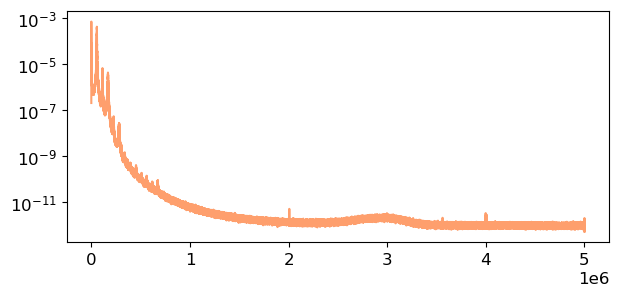

In [26]:
plt.plot(ffz, ppz)
plt.yscale('log')

In [27]:
def cal_peak(ff, pp, lb, ub, p0=[5e7, 61000*2*np.pi, 8000]):
    popt, omega_fit, p_fit = fit_peak(ff[lb:ub]*2*np.pi, pp[lb:ub], peak_func, p0=p0)
    amp, omega_1mbar, gamma_1mbar = popt[0], popt[1], popt[2]

    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(ff[lb:ub], pp[lb:ub])
    ax.plot(omega_fit/(2*np.pi), p_fit)
    ax.set_title('No driving field')
    ax.set_xlabel('Frequency $\omega / 2 \pi$ (Hz)')
    ax.set_ylabel('Spectral density ($V^2 / Hz$)')
    ax.set_yscale('log')

    # Derive the calibration factor assumed mass and
    # thermal equilibrium at 300 K
    T   = 300  # K
    kb  = 1.38e-23
    
    # Use this value after ethanol is gone
    rho = 2000 # kg/m^3
    r   = 166e-9 / 2
    m   = rho * (4 * np.pi / 3) * r**3
    
    # Again need to take care of 2 pi normalization
    # because the formula assume integrating over `omega`, not `f`
    v2 = 0.5 * np.pi/(gamma_1mbar * omega_1mbar**2) * amp * gamma_1mbar / (2 * np.pi)
    
    # Calibration factor converting <V^2> to (x^2)
    c_cal_square = (v2 * m * omega_1mbar**2) / (kb * T)
    print(fr'Calibration factor square $c^2$: {c_cal_square}')

    return c_cal_square

Calibration factor square $c^2$: 137878939276008.58


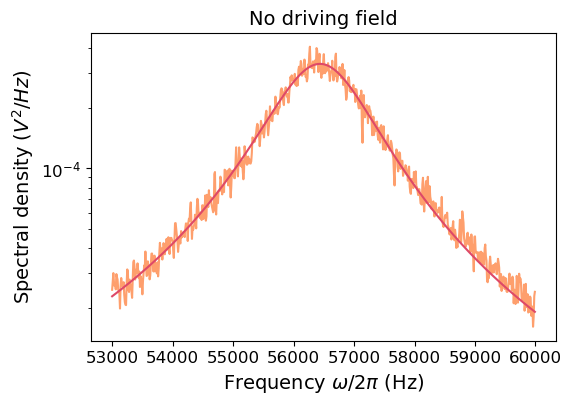

In [28]:
c_2_z_back = cal_peak(ffz, ppz, 5300, 6000, [1e11, 58000*2*np.pi, 8000])

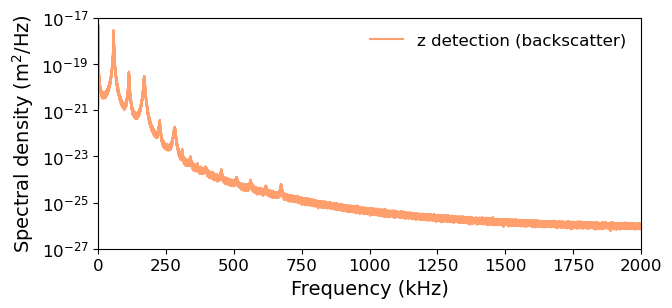

In [35]:
plt.plot(ffz/1000, ppz/c_2_z_back, label='z detection (backscatter)')

plt.xlim(0, 2000)
plt.ylim(1e-27, 1e-17)
plt.xlabel('Frequency (kHz)')
plt.ylabel('Spectral density (m$^2$/Hz)')
plt.legend(frameon=False)
plt.yscale('log')

### Data for a sphere (2024/07/03)

All data are low pass filtered to avoild aliasing (A, B, D: 1.7 MHz; C: 500 kHz) and digitized at 5 MHz. All spectra are averaged over 5 seconds.

In [62]:
data_dir = r"D:\noise"
prefix = r"20240703_all_1mbar"
file_list = glob.glob(f"{data_dir}\{prefix}\*.mat")

dt = 0
xx_list, yy_list, zz_list, zb_list = [], [], [], []
for f in file_list[0:5]:
    dtt, tt, nn = load_timestreams(f, ['A', 'B', 'C', 'D'])
    yy_list.append(nn[0])
    xx_list.append(nn[1])
    zz_list.append(nn[2])
    zb_list.append(nn[3])
    dt = dtt
nnx = np.concatenate(xx_list)
nny = np.concatenate(yy_list)
nnz = np.concatenate(zz_list)
nnzb = np.concatenate(zb_list)

In [63]:
ffy, ppy= get_psd(dtt, None, nny)
ffx, ppx= get_psd(dtt, None, nnx)
ffz, ppz= get_psd(dtt, None, nnz)
ffzb, ppzb= get_psd(dtt, None, nnzb)

Text(0.5, 1.0, 'Pressure = 1 mbar')

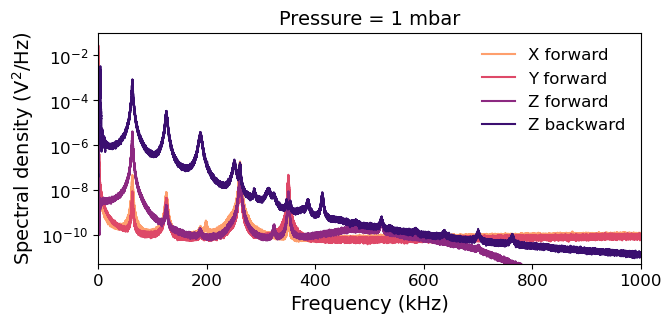

In [67]:
plt.plot(ffx/1e3, ppx, label='X forward')
plt.plot(ffy/1e3, ppy, label='Y forward')
plt.plot(ffz/1e3, ppz, label='Z forward')
plt.plot(ffzb/1e3, ppzb, label='Z backward')

plt.xlim(0, 1000)
plt.ylim(5e-12, 1e-1)
plt.yscale('log')
plt.legend(frameon=False)
plt.xlabel('Frequency (kHz)')
plt.ylabel('Spectral density (V$^2$/Hz)')
plt.title(r'Pressure = 1 mbar')

Calibration factor square $c^2$: 1361711169278.8462
Calibration factor square $c^2$: 1420196917866.9277
Calibration factor square $c^2$: 582537595160.2007
Calibration factor square $c^2$: 309922534407504.0


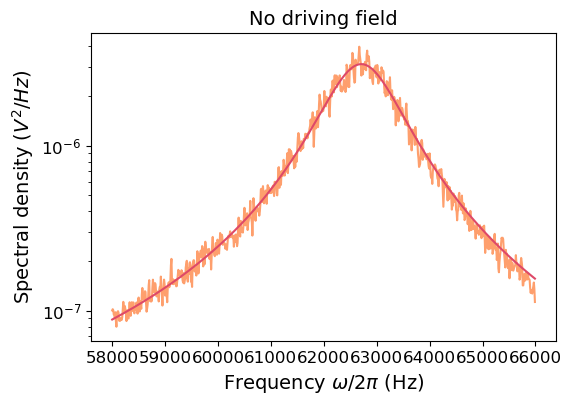

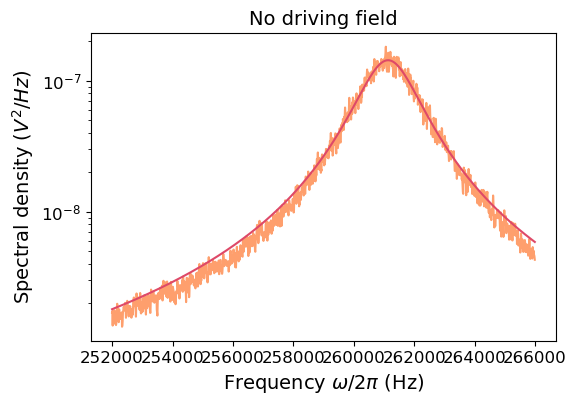

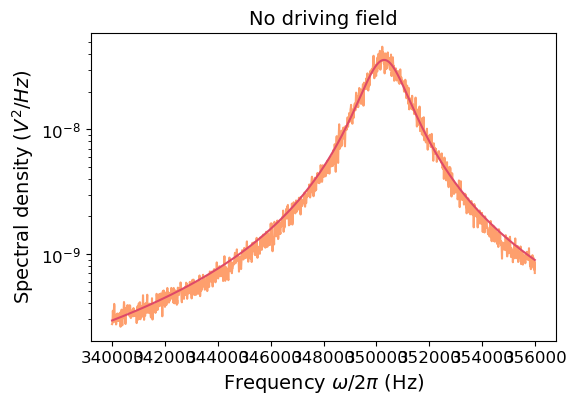

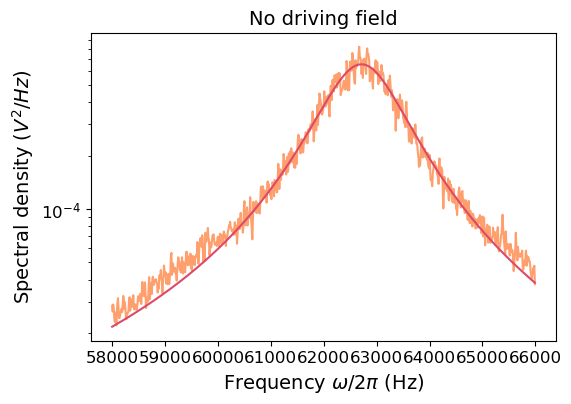

In [66]:
c_2_z = cal_peak(ffz, ppz, 5800, 6600, [5e7, 61000*2*np.pi, 8000])
c_2_x = cal_peak(ffx, ppx, 25200, 26600, p0=[5e7, 254000*2*np.pi, 8000])
c_2_y = cal_peak(ffy, ppy, 34000, 35600, [5e7, 342000*2*np.pi, 8000])
c_2_z_back = cal_peak(ffzb, ppzb, 5800, 6600, [1e11, 58000*2*np.pi, 8000])

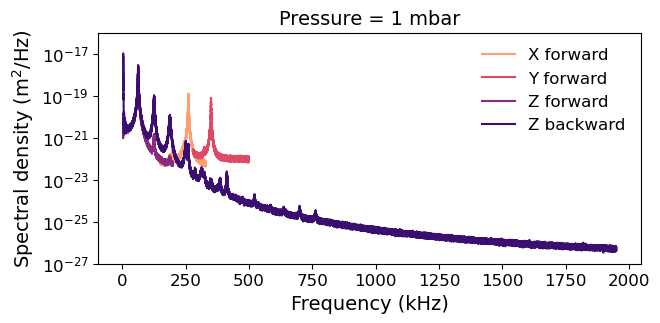

In [73]:
plt.plot(ffx[15000:33000]/1000, ppx[15000:33000]/c_2_x, label='X forward')
plt.plot(ffy[28000:50000]/1000, ppy[28000:50000]/c_2_y, label='Y forward')
plt.plot(ffz[300:20000]/1000, ppz[300:20000]/c_2_z, label='Z forward')
plt.plot(ffzb[300:195000]/1000, ppzb[300:195000]/c_2_z_back, label='Z backward')

plt.ylim(1e-27, 1e-16)
plt.title(r'Pressure = 1 mbar')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Spectral density (m$^2$/Hz)')
plt.legend(frameon=False)
plt.yscale('log')

In [79]:
data_dir = r"D:\noise"
prefix = r"20240704_backscatter_phaselocking\20240704_backscatter_7e-2mbar_withlock"
file_list = glob.glob(f"{data_dir}\{prefix}\*.mat")

dt = 0
zb_list = []
for f in file_list[0:5]:
    dtt, tt, nn = load_timestreams(f, ['D'])
    zb_list.append(nn[0])
    dt = dtt
nnzb = np.concatenate(zb_list)

In [80]:
data_dir = r"D:\noise"
prefix = r"20240704_backscatter_phaselocking\20240704_backscatter_7e-2mbar_nolock"
file_list = glob.glob(f"{data_dir}\{prefix}\*.mat")

dt = 0
zb_nl_list = []
for f in file_list[0:5]:
    dtt, tt, nn = load_timestreams(f, ['D'])
    zb_nl_list.append(nn[0])
    dt = dtt
nnzb_nl = np.concatenate(zb_nl_list)

In [81]:
ffzb, ppzb= get_psd(dt, None, nnzb)
ffzb_nl, ppzb_nl= get_psd(dt, None, nnzb_nl)

Text(0.5, 1.0, 'Pressure = 7 $\\times$ 10$^{-2}$ mbar')

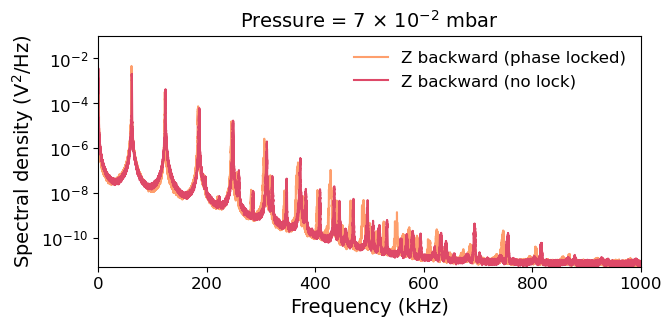

In [82]:
plt.plot(ffzb/1e3, ppzb, label='Z backward (phase locked)')
plt.plot(ffzb_nl/1e3, ppzb_nl, label='Z backward (no lock)')

plt.xlim(0, 1000)
plt.ylim(5e-12, 1e-1)
plt.yscale('log')
plt.legend(frameon=False)
plt.xlabel('Frequency (kHz)')
plt.ylabel('Spectral density (V$^2$/Hz)')
plt.title(r'Pressure = 7 $\times$ 10$^{-2}$ mbar')